# QUANTUM PHASE ESTIMATION

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

This tutorial provides a detailed implementation of the Quantum Phase Estimation (QPE) algorithm using the Amazon Braket SDK.
The QPE algorithm is designed to estimate the eigenvalues of a unitary operator $U$ [1, 2]; 
it is a very important subroutine to many quantum algorithms, most famously Shor's algorithm for factoring and the HHL algorithm (named after the physicists Harrow, Hassidim and Lloyd) for solving linear systems of equations on a quantum computer [1, 2]. 
Moreover, eigenvalue problems can be found across many disciplines and application areas, including (for example) principal component analysis (PCA) as used in machine learning or the solution of differential equations as relevant across mathematics, physics, engineering and chemistry. 
We first review the basics of the QPE algorithm.
We then implement the QPE algorithm in code using the Amazon Braket SDK, and we illustrate the application thereof with simple examples. 
This notebook also showcases the Amazon Braket `circuit.subroutine` functionality, which allows us to use custom-built gates as if they were any other built-in gates. 
This tutorial is set up to run either on the local simulator or the on-demand simulators; changing between these devices merely requires changing one line of code as demonstrated as follows in cell [4]. 

## TECHNICAL BACKGROUND OF QPE 

__Introduction__: A unitary matrix is a complex, square matrix whose adjoint (or conjugate transpose) is equal to its inverse. Unitary matrices have many nice properties, including the fact that their eigenvalues are always roots of unity (that is, phases). Given a unitary matrix $U$ (satisfying $U^{\dagger}U=\mathbb{1}=UU^{\dagger}$) and an eigenstate $|\psi \rangle$ with $U|\psi \rangle = e^{2\pi i\varphi}|\psi \rangle$, the Quantum Phase Estimation (QPE) algorithm provides an estimate $\tilde{\varphi} \approx \varphi$ for the phase $\varphi$ (with $\varphi \in [0,1]$ since the eigenvalues $\lambda = \exp(2\pi i\varphi)$ of a unitary have modulus one). 
The QPE works with high probability within an additive error $\varepsilon$ using $O(\log(1/\varepsilon))$ qubits (without counting the qubits used to encode the eigenstate) and $O(1/\varepsilon)$ controlled-$U$ operations [1].

__Quantum Phase Estimation Algorithm__: 
The QPE algorithm takes a unitary $U$ as input. For the sake of simplicity (we will generalize the discussion below), suppose that the algorithm also takes as input an eigenstate $|\psi \rangle$ fulfilling 

$$U|\psi \rangle = \lambda |\psi \rangle,$$

with $\lambda = \exp(2\pi i\varphi)$. 

QPE uses two registers of qubits: we refer to the first register as *precision* qubits (as the number of qubits $n$ in the first register sets the achievable precision of our results) and the second register as *query* qubits (as the second register hosts the eigenstate $|\psi \rangle$). 
Suppose we have prepared this second register in $|\psi \rangle$.  We then prepare a uniform superposition of all basis vectors in the first register using a series of Hadamard gates. 

Next, we apply a series of controlled-unitaries $C-U^{2^{k}}$ for different powers of $k=0,1,\dots, n-1$ (as illustrated in the circuit diagram that follows). 
For example, for $k=1$ we get
\begin{equation} 
\begin{split}
(|0 \rangle + |1 \rangle) |\psi \rangle  & \rightarrow |0 \rangle |\psi \rangle + |1 \rangle U|\psi \rangle \\
& = (|0 \rangle + e^{2\pi i \varphi}|1 \rangle) |\psi \rangle.
\end{split}
\end{equation}

Note that the second register remains unaffected as it stays in the eigenstate $|\psi \rangle$. 
However, we managed to transfer information about the phase of the eigenvalue of $U$ (that is, $\varphi$) into the first *precision* register by encoding it as a relative phase in the state of the qubits in the first register. 

Similarly, for $k=2$ we obtain
\begin{equation} 
\begin{split}
(|0 \rangle + |1 \rangle) |\psi \rangle  & \rightarrow |0 \rangle |\psi \rangle + |1 \rangle U^{2}|\psi \rangle \\
& = (|0 \rangle + e^{2\pi i 2\varphi}|1 \rangle) |\psi \rangle,
\end{split}
\end{equation}

where this time we wrote $2\varphi$ into the precision register. The process is similar for all $k>2$.

Introducing the following notation for binary fractions
$$[0. \varphi_{l}\varphi_{l+1}\dots \varphi_{m}] = \frac{\varphi_{l}}{2^{1}} + \frac{\varphi_{l+1}}{2^{2}} + \frac{\varphi_{m}}{2^{m-l+1}},$$ 

one can show that the application of a controlled unitary $C-U^{2^{k}}$ leads to the following transformation

\begin{equation} 
\begin{split}
(|0 \rangle + |1 \rangle) |\psi \rangle  & \rightarrow |0 \rangle |\psi \rangle + |1 \rangle U^{2^{k}}|\psi \rangle \\
& = (|0 \rangle + e^{2\pi i 2^{k}\varphi}|1 \rangle) |\psi \rangle \\
& = (|0 \rangle + e^{2\pi i [0.\varphi_{k+1}\dots \varphi_{n}]}|1 \rangle) |\psi \rangle,
\end{split}
\end{equation}

where the first $k$ bits of precision in the binary expansion (that is, those bits to the left of the decimal) can be dropped, because $e^{2\pi i \theta} = 1$ for any whole number $\theta$.

The QPE algorithm implements a series of these transformations for $k=0, 1, \dots, n-1$, using $n$ qubits in the precision register. 
In its entirety, this sequence of controlled unitaries leads to the transformation

$$ |0, \dots, 0 \rangle \otimes |\psi \rangle \longrightarrow 
(|0 \rangle + e^{2\pi i [0.\varphi_{n}]}|1 \rangle) 
\otimes (|0 \rangle + e^{2\pi i [0.\varphi_{n-1}\varphi_{n}]}|1 \rangle)
\otimes \dots
\otimes (|0 \rangle + e^{2\pi i [0.\varphi_{1}\dots\varphi_{n}]}|1 \rangle) 
\otimes |\psi \rangle.
$$

By inspection, one can see that the state of the register qubits above corresponds to a quantum Fourier transform of the state $|\varphi_1,\dots,\varphi_n\rangle$. Thus, the final step of the QPE algorithm is to run the *inverse* Quantum Fourier Transform (QFT) algorithm on the precision register to extract the phase information from this state. The resulting state is
$$|\varphi_{1}, \varphi_{2}, \dots, \varphi_{n}  \rangle \otimes |\psi\rangle.$$

Measuring the precision qubits in the computational basis then gives the classical bitstring $\varphi_{1}, \varphi_{2}, \dots, \varphi_{n}$, from which we can readily infer the phase estimate $\tilde{\varphi} = 0.\varphi_{1} \dots \varphi_{n}$ with the corresponding eigenvalue $\tilde{\lambda} = \exp(2\pi i \tilde{\varphi})$.
 
__Simple example for illustration__: For concreteness, consider a simple example with the unitary given by the Pauli $X$ gate, $U=X$, for which $|\Psi \rangle = |+\rangle = (|0 \rangle + |1 \rangle)/\sqrt{2}$ is an eigenstate with eigenvalue $\lambda = 1$, i.e., $\varphi=0$. 
This state can be prepared with a Hadamard gate as $|\Psi \rangle = H|0 \rangle$. 
We take a precision register consisting of just two qubits ($n=2$). 

Thus, after the first layer of Hadamard gates, the quantum state is
$$|0,0,0 \rangle \rightarrow |+,+,+\rangle.$$

Next, the applications of the controlled-$U$ gates (equal to $C-X$ operations, or CNOT gates in this example) leave this state untouched, because $|+\rangle$ is an eigenstate of $X$ with eigenvalue $+1$. 
Finally, applying the inverse QFT leads to 

$$\mathrm{QFT}^{\dagger}|+++\rangle=\mathrm{QFT}^\dagger\frac{|00\rangle + |01\rangle + |10\rangle + |11\rangle}{4}\otimes |+\rangle = |00\rangle \otimes |+\rangle,$$

from which we deduce $\varphi = [0.00]=0$ and therefore $\lambda=1$, as expected. 
Here, in the last step we have used $|00\rangle + |01\rangle + |10\rangle + |11\rangle = (|0\rangle + e^{2\pi i[0.0]}|1\rangle)(|0\rangle + e^{2\pi i[0.00]}|1\rangle)$, which makes the effect of the inverse QFT more apparent.  

__Initial state of query register__: So far, we have assumed that the query register is prepared in an eigenstate $|\Psi\rangle$ of $U$. What happens if this is not the case? Let's reconsider the simple example given previously.

Suppose now that the query register is instead prepared in the state $|\Psi\rangle = |1\rangle$. 
We can always express this state in the eigenbasis of $U$, that is, $|1\rangle = \frac{1}{\sqrt{2}}(|+\rangle - |-\rangle)$. 
By linearity, application of the QPE algorithm then gives (up to normalization)

\begin{equation} 
\begin{split}
\mathrm{QPE}(|0,0,\dots\rangle \otimes |1\rangle) & = \mathrm{QPE}(|0,0,\dots\rangle \otimes |+\rangle)
- \mathrm{QPE}(|0,0,\dots\rangle \otimes |-\rangle) \\
& =  |\varphi_{+}\rangle \otimes |+\rangle - |\varphi_{-}\rangle \otimes |-\rangle. \\
\end{split}
\end{equation}

When we measure the precision qubits in this state, 50% of the time we will observe the eigenphase $\varphi_{+}$ and 50% of the time we will measure $\varphi_{-}$. We illustrate this example numerically as follows.

This example motivates the general case: we can pass a state that is not an eigenstate of $U$ to the QPE algorithm, but we may need to repeat our measurements several times in order to obtain an estimate of the desired phase.

## CIRCUIT IMPLEMENTATION OF QPE

The QPE circuit can be implemented using Hadamard gates, controlled-$U$ unitaries, and the inverse QFT (denoted as $\mathrm{QFT}^{-1}$). 
The details of the calculation can be found in a number of resources (such as, [1]); we omit them here.
Following the previous discussion, the circuit that implements the QPE algorithm reads as below, where m is the size of lower query register and n is the size of upper precision register.

<div align="center"><img src="circuit.png"/></div>
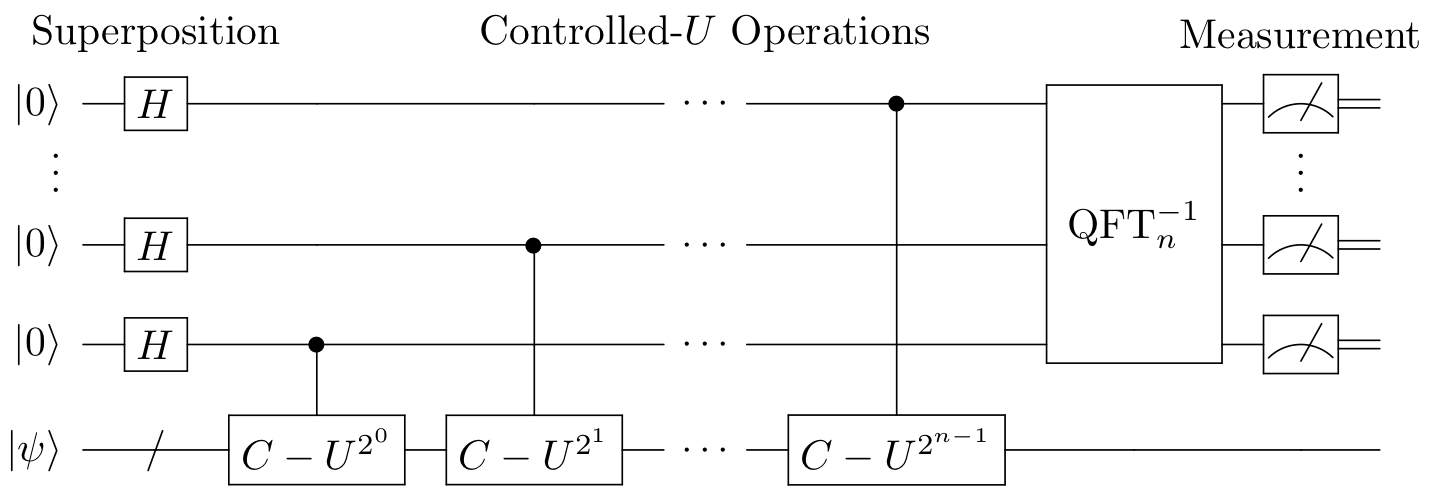

## IMPORTS and SETUP

In [2]:
# general imports
import numpy as np
import math
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

In [3]:
# AWS imports: Import Amazon Braket SDK modules
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

In [4]:
# local imports
from utils_qpe import qpe, run_qpe

%load_ext autoreload
%autoreload 2

In [5]:
# set up device: local simulator or the on-demand simulator
device = LocalSimulator()
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

### Pauli Matrices:
In some of our examples, we choose the unitary $U$ to be given by the **Pauli Matrices**, which we thus define as follows:

In [6]:
# Define Pauli matrices
Id = np.eye(2)             # Identity matrix
X = np.array([[0., 1.],
              [1., 0.]])   # Pauli X
Y = np.array([[0., -1.j],
              [1.j, 0.]])  # Pauli Y
Z = np.array([[1., 0.],
              [0., -1.]])  # Pauli Z

## IMPLEMENTATION OF THE QPE CIRCUIT

In ```utils_qpe.py``` we provide simple helper functions to implement the quantum circuit for the QPE algorithm. 
Specifically, we demonstrate that such modular building blocks can be registered as subroutines, using ```@circuit.subroutine(register=True)```. 
Moreover, we provide a helper function (called ```get_qpe_phases```) to perform postprocessing based on the measurement results to extract the phase. The details of ```utils_qpe.py``` are shown in the Appendix.

To implement the unitary $C-U^{2^k}$, one can use the fact that $C-U^{2} = (C-U)(C-U)$, so that $C-U^{2^{k}}$ can be constructed by repeatedly applying the core building block $C-U$. 
However, the circuit generated using this approach will have a significantly larger depth. In our implementation, we instead define the matrix $U^{2^k}$ and create the controlled $C-(U^{2^k})$ gate from that.

## VISUALIZATION OF THE QFT CIRCUIT

To check our implementation of the QPE circuit, we visualize this circuit for a small number of qubits. 

In [7]:
# set total number of qubits
precision_qubits = [0, 1]
query_qubits = [2]

# prepare query register
my_qpe_circ = Circuit().h(query_qubits)

# set unitary
unitary = X

# show small QPE example circuit
my_qpe_circ = my_qpe_circ.qpe(precision_qubits, query_qubits, unitary)
print('QPE CIRCUIT:')
print(my_qpe_circ)

QPE CIRCUIT:
T  : |0|1|2| 3  |4|     5      |6|
                                  
q0 : -H---U-SWAP---PHASE(-1.57)-H-
          | |      |              
q1 : -H-U-|-SWAP-H-C--------------
        | |                       
q2 : -H-U-U-----------------------

T  : |0|1|2| 3  |4|     5      |6|


As shown in the following code, the two registers can be distributed anywhere across the circuit, with arbitrary indices for the precision and the query registers.  

In [8]:
# set qubits
precision_qubits = [1, 3]
query_qubits = [5]

# prepare query register
my_qpe_circ = Circuit().i(range(7))
my_qpe_circ.h(query_qubits)

# set unitary
unitary = X

# show small QPE example circuit
my_qpe_circ = my_qpe_circ.qpe(precision_qubits, query_qubits, unitary)
print('QPE CIRCUIT:')
print(my_qpe_circ)

QPE CIRCUIT:
T  : |0|1|2|3| 4  |5|     6      |7|
                                    
q0 : -I-----------------------------
                                    
q1 : -I-H---U-SWAP---PHASE(-1.57)-H-
            | |      |              
q2 : -I-----|-|------|--------------
            | |      |              
q3 : -I-H-U-|-SWAP-H-C--------------
          | |                       
q4 : -I---|-|-----------------------
          | |                       
q5 : -I-H-U-U-----------------------
                                    
q6 : -I-----------------------------

T  : |0|1|2|3| 4  |5|     6      |7|


As follows, we set up the same circuit, this time implementing the unitary $C-U^{2^k}$, by repeatedly applying the core building block $C-U$. 
This operation can be done by setting the parameter ```control_unitary=False``` (default is ```True```). 

In [9]:
# set qubits
precision_qubits = [1, 3]
query_qubits = [5]

# prepare query register
my_qpe_circ = Circuit().i(range(7))
my_qpe_circ.h(query_qubits)

# set unitary
unitary = X

# show small QPE example circuit
my_qpe_circ = my_qpe_circ.qpe(precision_qubits, query_qubits, unitary, control_unitary=False)
print('QPE CIRCUIT:')
print(my_qpe_circ)

QPE CIRCUIT:
T  : |0|1|2|3|4| 5  |6|     7      |8|
                                      
q0 : -I-------------------------------
                                      
q1 : -I-H---U-U-SWAP---PHASE(-1.57)-H-
            | | |      |              
q2 : -I-----|-|-|------|--------------
            | | |      |              
q3 : -I-H-U-|-|-SWAP-H-C--------------
          | | |                       
q4 : -I---|-|-|-----------------------
          | | |                       
q5 : -I-H-U-U-U-----------------------
                                      
q6 : -I-------------------------------

T  : |0|1|2|3|4| 5  |6|     7      |8|


In the circuit diagram, we can visually infer the exponents for $k=0,1$, at the expense of a larger circuit depth. 

## NUMERICAL TEST EXPERIMENTS

In the following section, we verify that our QFT implementation works as expected with a few test examples:
1. We run QPE with $U=X$ and prepare the eigenstate $|\Psi\rangle = |+\rangle = H|0\rangle$ with phase $\varphi=0$ and eigenvalue $\lambda=1$. 
2. We run QPE with $U=X$ and prepare the eigenstate $|\Psi\rangle = |-\rangle = HX|0\rangle$ with phase $\varphi=0.5$ and eigenvalue $\lambda=-1$. 
3. We run QPE with $U=X$ and prepare $|\Psi\rangle = |1\rangle = X|0\rangle$ which is *not* an eigenstate of $U$. 
Because $|1\rangle = (|+\rangle - |-\rangle)/\sqrt{2}$, we expect to measure both $\varphi=0$ and $\varphi=0.5$ associated with the two eigenstates $|\pm\rangle$. 
4. We run QPE with unitary $U=X \otimes Z$, and prepare the query register in the eigenstate $|\Psi\rangle = |+\rangle \otimes |1\rangle = H|0\rangle \otimes Z|0\rangle$. 
Here, we expect to measure the phase $\varphi=0.5$ (giving the corresponding eigenvalue $\lambda=-1$). 
5. We run QPE with a _random_ two qubit unitary, diagonal in the computational basis, and prepare the query register in the eigenstate $|11\rangle$.
In this case, we should be able to read off the eigenvalue and phase from $U$ and verify QPE gives the right answer (with high probability) up to a small error (that depends on the number of qubits in the precision register).

## HELPER FUNCTIONS FOR NUMERICAL TESTS
Because we will run the same code repeatedly, let's first create a helper function we can use to keep the notebook clean.

In [10]:
def postprocess_qpe_results(out):
    """
    Function to postprocess dictionary returned by run_qpe

    Args:
        out: dictionary containing results/information associated with QPE run as produced by run_qpe
    """
    
    # unpack results
    circ = out['circuit']
    measurement_counts = out['measurement_counts']
    bitstring_keys = out['bitstring_keys']
    probs_values = out['probs_values']
    precision_results_dic = out['precision_results_dic']
    phases_decimal = out['phases_decimal']
    eigenvalues = out['eigenvalues']
    
    # print the circuit 
    print('Printing circuit:')
    print(circ)
    
    # print measurement results
    print('Measurement counts:', measurement_counts)
    
    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);

    # print results
    print('Results in precision register:', precision_results_dic)
    print('QPE phase estimates:', phases_decimal)
    print('QPE eigenvalue estimates:', np.round(eigenvalues, 5))

### NUMERICAL TEST EXAMPLE 1

First, apply the QPE algorithm to the simple single-qubit unitary $U=X$, with eigenstate $|\Psi\rangle = |+\rangle = H|0\rangle$. Here, we expect to measure the phase $\varphi=0$ (giving the corresponding eigenvalue $\lambda=1$). 
We show that this result stays the same as we increase the number of qubits $n$ for the top register. 

Printing circuit:
T  : |0|1|2| 3  |4|     5      |6|Result Types|
                                               
q0 : -H---U-SWAP---PHASE(-1.57)-H-Probability--
          | |      |              |            
q1 : -H-U-|-SWAP-H-C--------------Probability--
        | |                       |            
q2 : -H-U-U-----------------------Probability--

T  : |0|1|2| 3  |4|     5      |6|Result Types|
Measurement counts: Counter({'000': 504, '001': 496})
Results in precision register: {'00': 1000}
QPE phase estimates: [0.0]
QPE eigenvalue estimates: [1.+0.j]


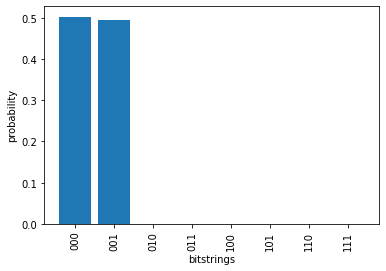

In [11]:
# Set total number of precision qubits: 2
number_precision_qubits = 2

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits]

# State preparation for eigenstate of U=X
query = Circuit().h(query_qubits)

# Run the test with U=X
out = run_qpe(X, precision_qubits, query_qubits, query, device)

# Postprocess results
postprocess_qpe_results(out)

Next, check that we get the same result for a larger precision (top) register. 

Printing circuit:
T  : |0|1|2|3| 4  |5|     6      |       7       |     8      |9|Result Types|
                                                                              
q0 : -H-----U-SWAP------------------PHASE(-0.785)-PHASE(-1.57)-H-Probability--
            | |                     |             |              |            
q1 : -H---U-|-|------PHASE(-1.57)-H-|-------------C--------------Probability--
          | | |      |              |                            |            
q2 : -H-U-|-|-SWAP-H-C--------------C----------------------------Probability--
        | | |                                                    |            
q3 : -H-U-U-U----------------------------------------------------Probability--

T  : |0|1|2|3| 4  |5|     6      |       7       |     8      |9|Result Types|
Measurement counts: Counter({'0000': 504, '0001': 496})
Results in precision register: {'000': 1000}
QPE phase estimates: [0.0]
QPE eigenvalue estimates: [1.+0.j]


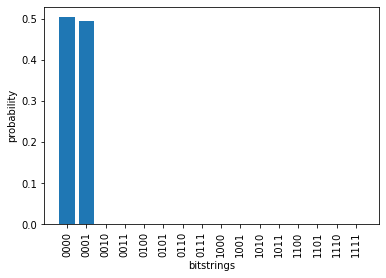

In [12]:
# Set total number of precision qubits: 3
number_precision_qubits = 3

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits]

# State preparation for eigenstate of U=X
query = Circuit().h(query_qubits)

# Run the test with U=X
out = run_qpe(X, precision_qubits, query_qubits, query, device)

# Postprocess results
postprocess_qpe_results(out)

### NUMERICAL TEST EXAMPLE 2

Next, apply the QPE algorithm to the simple single-qubit unitary $U=X$, with eigenstate $|\Psi\rangle = |-\rangle = HX|0\rangle$. 
Here, we expect to measure the phase $\varphi=0.5$ (giving the corresponding eigenvalue $\lambda=-1$). 

Printing circuit:
T  : |0|1|2|3| 4  |5|     6      |7|Result Types|
                                                 
q0 : -H-----U-SWAP---PHASE(-1.57)-H-Probability--
            | |      |              |            
q1 : -H---U-|-SWAP-H-C--------------Probability--
          | |                       |            
q2 : -X-H-U-U-----------------------Probability--

T  : |0|1|2|3| 4  |5|     6      |7|Result Types|
Measurement counts: Counter({'100': 516, '101': 484})
Results in precision register: {'10': 1000}
QPE phase estimates: [0.5]
QPE eigenvalue estimates: [-1.+0.j]


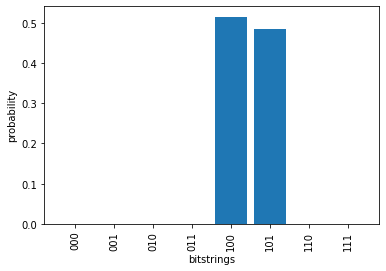

In [13]:
# Set total number of precision qubits: 2
number_precision_qubits = 2

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits]

# State preparation for eigenstate of U=X
query = Circuit().x(query_qubits).h(query_qubits)

# Run the test with U=X
out = run_qpe(X, precision_qubits, query_qubits, query, device)

# Postprocess results
postprocess_qpe_results(out)

### NUMERICAL TEST EXAMPLE 3

Next, apply the QPE algorithm again to the simple single-qubit unitary $U=X$, but we initialize the query register in the state $|\Psi\rangle = |1\rangle$ which is *not* an eigenstate of $U$. 
Here, following the previous discussion, we expect to measure the phases $\varphi=0, 0.5$ (giving the corresponding eigenvalue $\lambda=\pm 1$). Accordingly, here we set ```items_to_keep=2```. 

Printing circuit:
T  : |0|1|2| 3  |4|     5      |6|Result Types|
                                               
q0 : -H---U-SWAP---PHASE(-1.57)-H-Probability--
          | |      |              |            
q1 : -H-U-|-SWAP-H-C--------------Probability--
        | |                       |            
q2 : -X-U-U-----------------------Probability--

T  : |0|1|2| 3  |4|     5      |6|Result Types|
Measurement counts: Counter({'000': 261, '100': 256, '101': 242, '001': 241})
Results in precision register: {'10': 498, '00': 502}
QPE phase estimates: [0.0, 0.5]
QPE eigenvalue estimates: [ 1.+0.j -1.+0.j]


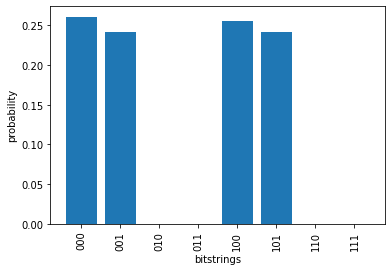

In [14]:
# Set total number of precision qubits: 2
number_precision_qubits = 2

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits]

# State preparation for |1>, which is not an eigenstate of U=X
query = Circuit().x(query_qubits)

# Run the test with U=X
out = run_qpe(X, precision_qubits, query_qubits, query, device, items_to_keep=2)

# Postprocess results
postprocess_qpe_results(out)

### NUMERICAL TEST EXAMPLE 4

Next, apply the QPE algorithm to the two-qubit unitary $U=X \otimes Z$, and prepare the query register in the eigenstate $|\Psi\rangle = |+\rangle \otimes |1\rangle = H|0\rangle \otimes X|0\rangle$. 
Here, we expect to measure the phase $\varphi=0.5$ (giving the corresponding eigenvalue $\lambda=-1$). 

In [15]:
# set unitary matrix U
u1 = np.kron(X, Id) 
u2 = np.kron(Id, Z)
unitary = np.dot(u1, u2)
print('Two-qubit unitary (XZ):\n', unitary)

# get example eigensystem 
eig_values, eig_vectors = np.linalg.eig(unitary)
print('Eigenvalues:', eig_values)
# print('Eigenvectors:', eig_vectors)

Two-qubit unitary (XZ):
 [[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]]
Eigenvalues: [ 1. -1.  1. -1.]


Printing circuit:
T  : |0|1|2| 3  |4|     5      |6|Result Types|
                                               
q0 : -H---U-SWAP---PHASE(-1.57)-H-Probability--
          | |      |              |            
q1 : -H-U-|-SWAP-H-C--------------Probability--
        | |                       |            
q2 : -H-U-U-----------------------Probability--
        | |                       |            
q3 : -X-U-U-----------------------Probability--

T  : |0|1|2| 3  |4|     5      |6|Result Types|
Measurement counts: Counter({'1011': 503, '1001': 497})
Results in precision register: {'10': 1000}
QPE phase estimates: [0.5]
QPE eigenvalue estimates: [-1.+0.j]


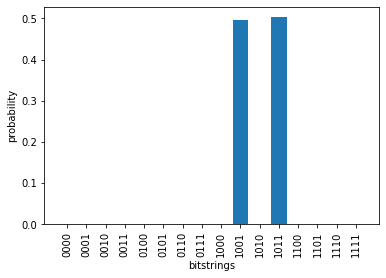

In [16]:
# Set total number of precision qubits: 2
number_precision_qubits = 2

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits, number_precision_qubits+1]

# State preparation for eigenstate |+,1> of U=X \otimes Z
query = Circuit().h(query_qubits[0]).x(query_qubits[1])

# Run the test with U=X
out = run_qpe(unitary, precision_qubits, query_qubits, query, device)

# Postprocess results
postprocess_qpe_results(out)

### NUMERICAL TEST EXAMPLE 5

In this example, we choose the unitary to be a _random_ two-qubit unitary, diagonal in the computational basis. We initialize the query register to be in the eigenstate $|11\rangle$ of $U$, which we can prepare using that $|11\rangle = X\otimes X|00\rangle$.
In this case we should be able to read off the eigenvalue and phase from $U$ and verify that QPE gives the right answer.

In [17]:
# Generate a random 2 qubit unitary matrix:
from scipy.stats import unitary_group

# Fix random seed for reproducibility
np.random.seed(seed=42)

# Get random two-qubit unitary
random_unitary = unitary_group.rvs(2**2)

# Let's diagonalize this
evals = np.linalg.eig(random_unitary)[0]

# Since we want to be able to read off the eigenvalues of the unitary in question
# let's choose our unitary to be diagonal in this basis
unitary = np.diag(evals)

# Check that this is indeed unitary, and print it out:
print('Two-qubit random unitary:\n', np.round(unitary, 3))
print('Check for unitarity: ', np.allclose(np.eye(len(unitary)), unitary.dot(unitary.T.conj())))

# Print eigenvalues
print('Eigenvalues:', np.round(evals, 3))

Two-qubit random unitary:
 [[-0.078+0.997j  0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.987-0.159j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.192-0.981j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.747-0.665j]]
Check for unitarity:  True
Eigenvalues: [-0.078+0.997j -0.987-0.159j  0.192-0.981j  0.747-0.665j]


When we execute the QPE circuit, we expect the following (approximate) result for the eigenvalue estimate: 

In [18]:
print('Target eigenvalue:', np.round(evals[-1], 3))

Target eigenvalue: (0.747-0.665j)


Printing circuit:
T  : |0|1|2|3| 4  |5|     6      |       7       |     8      |9|Result Types|
                                                                              
q0 : -H-----U-SWAP------------------PHASE(-0.785)-PHASE(-1.57)-H-Probability--
            | |                     |             |              |            
q1 : -H---U-|-|------PHASE(-1.57)-H-|-------------C--------------Probability--
          | | |      |              |                            |            
q2 : -H-U-|-|-SWAP-H-C--------------C----------------------------Probability--
        | | |                                                    |            
q3 : -X-U-U-U----------------------------------------------------Probability--
        | | |                                                    |            
q4 : -X-U-U-U----------------------------------------------------Probability--

T  : |0|1|2|3| 4  |5|     6      |       7       |     8      |9|Result Types|
Measurement counts: Counter({'111

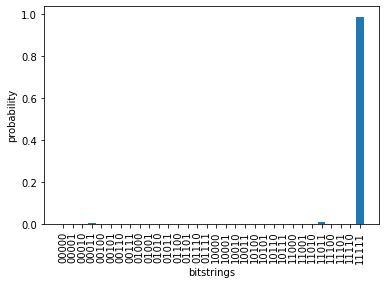

In [19]:
# Set total number of precision qubits
number_precision_qubits = 3

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits, number_precision_qubits+1]

# State preparation for eigenstate |1,1> of diagonal U
query = Circuit().x(query_qubits[0]).x(query_qubits[1])

# Run the test with U=X
out = run_qpe(unitary, precision_qubits, query_qubits, query, device)

# Postprocess results
postprocess_qpe_results(out)

# compare output to exact target values
print('Target eigenvalue:', np.round(evals[-1], 3))

We can easily improve the precision of our parameter estimate by increasing the number of qubits in the precision register, as shown in the following example. 

In [20]:
# Set total number of precision qubits
number_precision_qubits = 10

# Define the set of precision qubits
precision_qubits = range(number_precision_qubits)

# Define the query qubits. We'll have them start after the precision qubits
query_qubits = [number_precision_qubits, number_precision_qubits+1]

# State preparation for eigenstate |1,1> of diagonal U
query = Circuit().x(query_qubits[0]).x(query_qubits[1])

# Run the test with U=X
out = run_qpe(unitary, precision_qubits, query_qubits, query, device)

# Postprocess results
eigenvalues = out['eigenvalues']
print('QPE eigenvalue estimates:', np.round(eigenvalues, 5))

# compare output to exact target values
print('Target eigenvalue:', np.round(evals[-1], 5))

QPE eigenvalue estimates: [0.74506-0.667j]
Target eigenvalue: (0.74699-0.66484j)


---
## APPENDIX

In [21]:
# Check SDK version
# alternative: braket.__version__
!pip show amazon-braket-sdk | grep Version

Version: 0.6.0


## Details of the ```utiles_qpe.py``` module

### Imports, including inverse QFT

```python
# general imports
import numpy as np
import math
from collections import Counter
from datetime import datetime
import pickle

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, circuit

# local imports
from utils_qft import inverse_qft
```

### QPE Subroutine

```python
@circuit.subroutine(register=True)
def controlled_unitary(control, target_qubits, unitary):
    """
    Construct a circuit object corresponding to the controlled unitary

    Args:
        control: The qubit on which to control the gate

        target_qubits: List of qubits on which the unitary U acts

        unitary: matrix representation of the unitary we wish to implement in a controlled way
    """

    # Define projectors onto the computational basis
    p0 = np.array([[1., 0.],
                   [0., 0.]])

    p1 = np.array([[0., 0.],
                   [0., 1.]])

    # Instantiate circuit object
    circ = Circuit()

    # Construct numpy matrix
    id_matrix = np.eye(len(unitary))
    controlled_matrix = np.kron(p0, id_matrix) + np.kron(p1, unitary)

    # Set all target qubits
    targets = [control] + target_qubits

    # Add controlled unitary
    circ.unitary(matrix=controlled_matrix, targets=targets)

    return circ


@circuit.subroutine(register=True)
def qpe(precision_qubits, query_qubits, unitary, control_unitary=True):
    """
    Function to implement the QPE algorithm using two registers for precision (read-out) and query.
    Register qubits need not be contiguous.

    Args:
        precision_qubits: list of qubits defining the precision register

        query_qubits: list of qubits defining the query register

        unitary: Matrix representation of the unitary whose eigenvalues we wish to estimate

        control_unitary: Optional boolean flag for controlled unitaries,
                         with C-(U^{2^k}) by default (default is True),
                         or C-U controlled-unitary (2**power) times
    """
    qpe_circ = Circuit()

    # Get number of qubits
    num_precision_qubits = len(precision_qubits)
    num_query_qubits = len(query_qubits)

    # Apply Hadamard across precision register
    qpe_circ.h(precision_qubits)

    # Apply controlled unitaries. Start with the last precision_qubit, and end with the first
    for ii, qubit in enumerate(reversed(precision_qubits)):
        # Set power exponent for unitary
        power = ii

        # Alterantive 1: Implement C-(U^{2^k})
        if control_unitary:
            # Define the matrix U^{2^k}
            Uexp = np.linalg.matrix_power(unitary,2**power)

            # Apply the controlled unitary C-(U^{2^k})
            qpe_circ.controlled_unitary(qubit, query_qubits, Uexp)
        # Alterantive 2: One can instead apply controlled-unitary (2**power) times to get C-U^{2^power}
        else:
            for _ in range(2**power):
                qpe_circ.controlled_unitary(qubit, query_qubits, unitary)

    # Apply inverse qft to the precision_qubits
    qpe_circ.inverse_qft(precision_qubits)

    return qpe_circ
```

### QPE postprocessing helper functions

```python
# helper function to remove query bits from bitstrings
def substring(key, precision_qubits):
    """
    Helper function to get substring from keys for dedicated string positions as given by precision_qubits.
    This function is necessary to allow for arbitrary qubit mappings in the precision and query registers
    (that is, so that the register qubits need not be contiguous.)

    Args:
        key: string from which we want to extract the substring supported only on the precision qubits

        precision_qubits: List of qubits corresponding to precision_qubits.
                          Currently assumed to be a list of integers corresponding to the indices of the qubits
    """
    short_key = ''
    for idx in precision_qubits:
        short_key = short_key + key[idx]

    return short_key


# helper function to convert binary fractional to decimal
# reference: https://www.geeksforgeeks.org/convert-binary-fraction-decimal/
def binaryToDecimal(binary):
    """
    Helper function to convert binary string (example: '01001') to decimal

    Args:
        binary: string which to convert to decimal fraction
    """

    length = len(binary)
    fracDecimal = 0

    # Convert fractional part of binary to decimal equivalent
    twos = 2

    for ii in range(length):
        fracDecimal += ((ord(binary[ii]) - ord('0')) / twos);
        twos *= 2.0

    # return fractional part
    return fracDecimal


# helper function for postprocessing based on measurement shots
def get_qpe_phases(measurement_counts, precision_qubits, items_to_keep=1):
    """
    Get QPE phase estimate from measurement_counts for given number of precision qubits

    Args:
        measurement_counts: measurement results from a device run

        precision_qubits: List of qubits corresponding to precision_qubits.
                          Currently assumed to be a list of integers corresponding to the indices of the qubits

        items_to_keep: number of items to return (topmost measurement counts for precision register)
    """

    # Aggregate the results (that is, ignore the query register qubits):

    # First get bitstrings with corresponding counts for precision qubits only
    bitstrings_precision_register = [substring(key, precision_qubits)  for key in measurement_counts.keys()]
    # Then keep only the unique strings
    bitstrings_precision_register_set = set(bitstrings_precision_register)
    # Cast as a list for later use
    bitstrings_precision_register_list = list(bitstrings_precision_register_set)

    # Now create a new dict to collect measurement results on the precision_qubits.
    # Keys are given by the measurement count substrings on the register qubits. Initialize the counts to zero.
    precision_results_dic = {key: 0 for key in bitstrings_precision_register_list}

    # Loop over all measurement outcomes
    for key in measurement_counts.keys():
        # Save the measurement count for this outcome
        counts = measurement_counts[key]
        # Generate the corresponding shortened key (supported only on the precision_qubits register)
        count_key = substring(key, precision_qubits)
        # Add these measurement counts to the corresponding key in our new dict
        precision_results_dic[count_key] += counts

    # Get topmost values only
    c = Counter(precision_results_dic)
    topmost= c.most_common(items_to_keep)
    # get decimal phases from bitstrings for topmost bitstrings
    phases_decimal = [binaryToDecimal(item[0]) for item in topmost]

    # Get decimal phases from bitstrings for all bitstrings
    # number_precision_qubits = len(precision_qubits)
    # Generate binary decimal expansion
    # phases_decimal = [int(key, 2)/(2**number_precision_qubits) for key in precision_results_dic]
    # phases_decimal = [binaryToDecimal(key) for key in precision_results_dic]

    return phases_decimal, precision_results_dic
```

### Run QPE experiments:

```python
def run_qpe(unitary, precision_qubits, query_qubits, query_circuit,
            device, items_to_keep=1, shots=1000, save_to_pck=False):
    """
    Function to run QPE algorithm end-to-end and return measurement counts.

    Args:
        precision_qubits: list of qubits defining the precision register

        query_qubits: list of qubits defining the query register

        unitary: Matrix representation of the unitary whose eigenvalues we wish to estimate

        query_circuit: query circuit for state preparation of query register

        items_to_keep: (optional) number of items to return (topmost measurement counts for precision register)

        device: Braket device backend

        shots: (optional) number of measurement shots (default is 1000)

        save_to_pck: (optional) save results to pickle file if True (default is False)
    """

    # get size of precision register and total number of qubits
    number_precision_qubits = len(precision_qubits)
    num_qubits = len(precision_qubits) + len(query_qubits)

    # Define the circuit. Start by copying the query_circuit, then add the QPE:
    circ = query_circuit
    circ.qpe(precision_qubits, query_qubits, unitary)

    # Add desired results_types
    circ.probability()

    # Run the circuit with all zeros input.
    # The query_circuit subcircuit generates the desired input from all zeros.
    # The following code executes the correct device.run call, depending on whether the backend is local or on-demand
    task = device.run(circ, shots=shots)

    # get result for this task
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # get output probabilities (see result_types above)
    probs_values = result.values[0]

    # get measurement results
    measurements = result.measurements
    measured_qubits = result.measured_qubits
    measurement_counts = result.measurement_counts
    measurement_probabilities = result.measurement_probabilities

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # QPE postprocessing
    phases_decimal, precision_results_dic = get_qpe_phases(measurement_counts, precision_qubits, items_to_keep)
    eigenvalues = [np.exp(2*np.pi*1j*phase) for phase in phases_decimal]

    # aggregate results
    out = {'circuit': circ,
           'task_metadata': metadata,
           'measurements': measurements,
           'measured_qubits': measured_qubits,
           'measurement_counts': measurement_counts,
           'measurement_probabilities': measurement_probabilities,
           'probs_values': probs_values,
           'bitstring_keys': bitstring_keys,
           'precision_results_dic': precision_results_dic,
           'phases_decimal': phases_decimal,
           'eigenvalues': eigenvalues}

    if save_to_pck:
        # store results: dump output to pickle with timestamp in filename
        time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
        results_file = 'results-'+time_now+'.pck'
        pickle.dump(out, open(results_file, "wb"))
        # you can load results as follows
        # out = pickle.load(open(results_file, "rb"))

    return out
```

---
## REFERENCES

[1] Wikipedia: https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm

[2] Nielsen, Michael A., Chuang, Isaac L. (2010). Quantum Computation and Quantum Information (2nd ed.). Cambridge: Cambridge University Press.

In [22]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Task Summary
{}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.00 USD
